### Senate Data

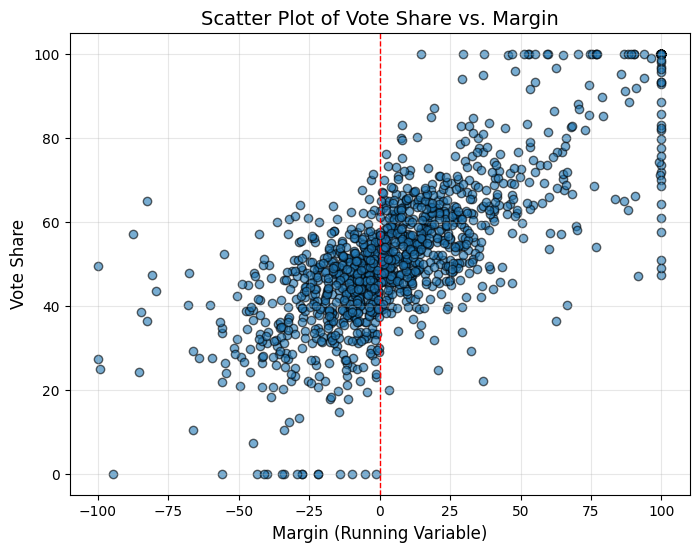

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("data/rdrobust_senate.csv")

# Define variables
margin = data['margin']
vote = data['vote']

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(margin, vote, alpha=0.6, edgecolor='k')
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Add cutoff line at x=0
plt.title("Scatter Plot of Vote Share vs. Margin", fontsize=14)
plt.xlabel("Margin (Running Variable)", fontsize=12)
plt.ylabel("Vote Share", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Sharp RD Design

,Polynomial Degree,Estimate,Robust SE,Robust CI Lower,Robust CI Upper,Left Bandwidth (h-),Right Bandwidth (h+)
0,1,7.414131,1.741258,4.093699,10.919306,17.754397,17.754397
1,2,8.045080,2.093029,4.214327,12.418851,22.256277,22.256277


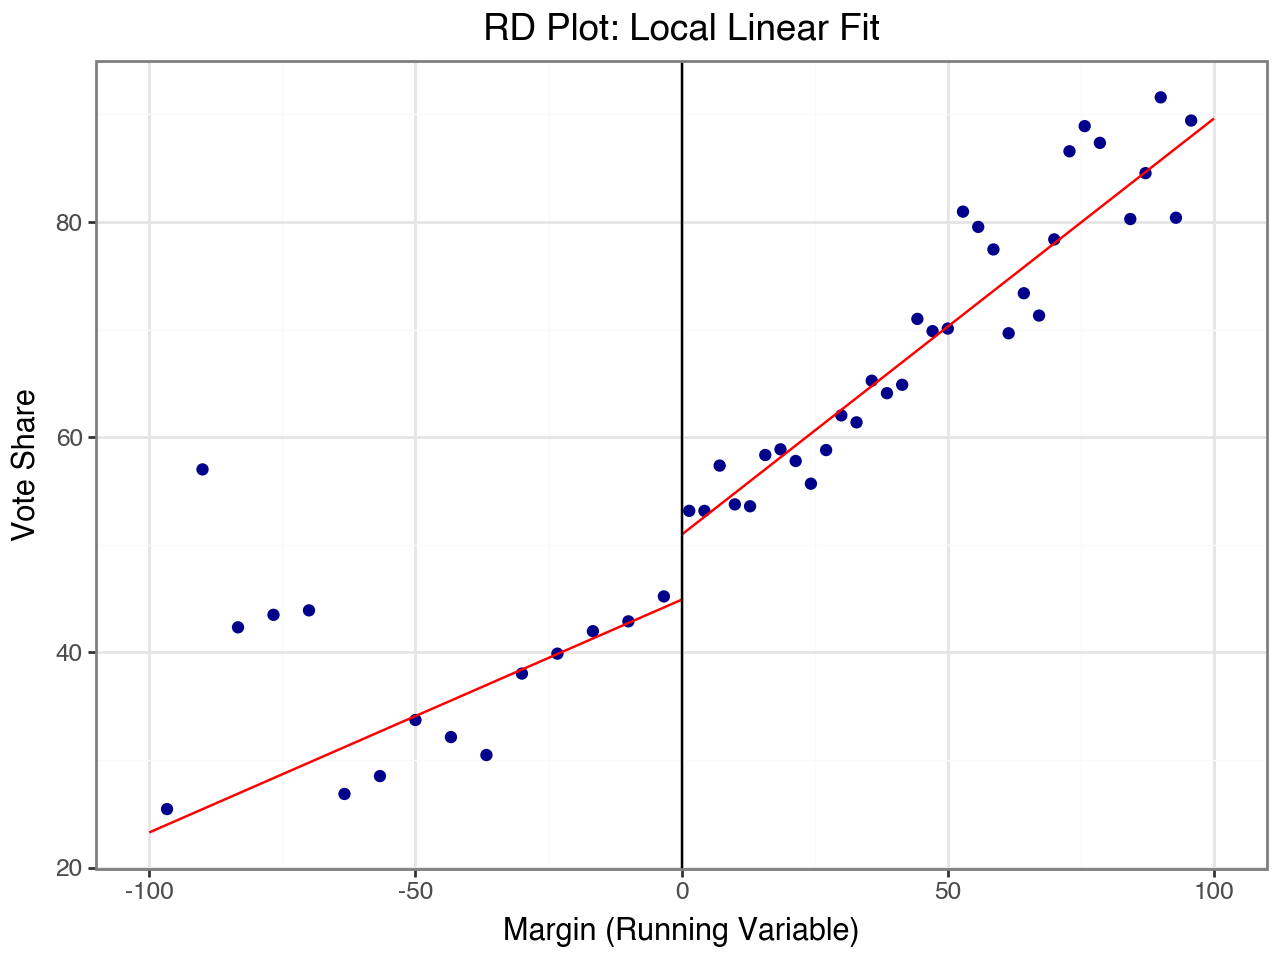

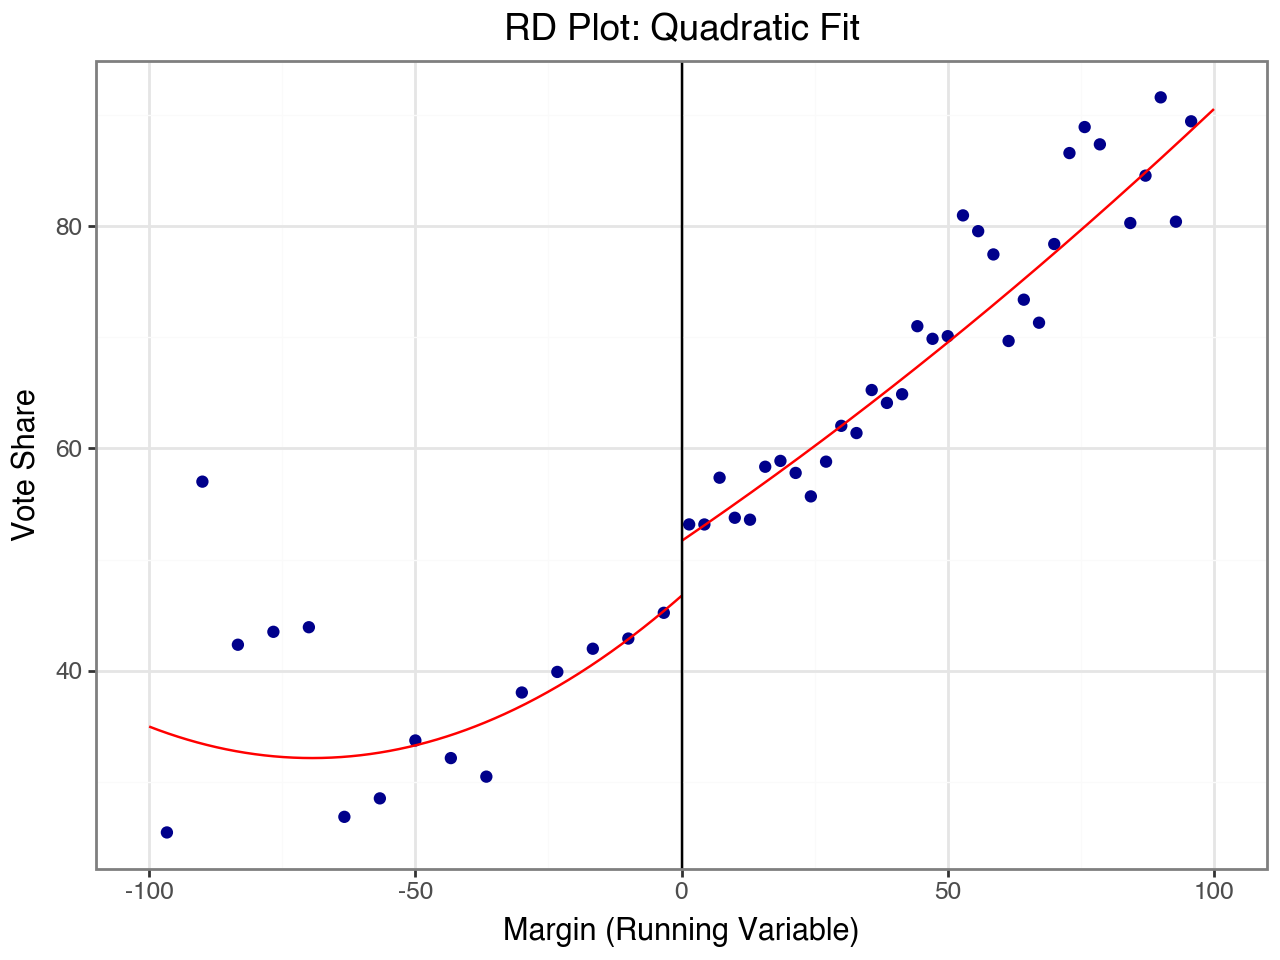

In [31]:
from rdrobust import rdrobust, rdplot
import pandas as pd

# Load the dataset
data = pd.read_csv("data/rdrobust_senate.csv")
margin = data['margin']
vote = data['vote']

# Perform RD estimation
result_linear = rdrobust(y=vote, x=margin, p=1, vce="nn") # nearest neighbor robust stderrs
result_quadratic = rdrobust(y=vote, x=margin, p=2, vce="nn")

def create_reg_table(result, poly_order):
    return {
        "Polynomial Degree": poly_order,
        "Estimate": result.Estimate.iloc[0][0],
        "Robust SE": result.se.iloc[2][0],  # Robust SE from the third row
        "Robust CI Lower": result.ci.iloc[2, 0],
        "Robust CI Upper": result.ci.iloc[2, 1],
        "Left Bandwidth (h-)": result.bws.loc['h', 'left'],
        "Right Bandwidth (h+)": result.bws.loc['h', 'right']
    }

linear_table = create_reg_table(result_linear, poly_order=1)
quadratic_table = create_reg_table(result_quadratic, poly_order=2)

regression_table = pd.DataFrame([linear_table, quadratic_table])
display(regression_table)


# Generate RD plot for linear fit (p=1)
rdplot(y=vote, x=margin,
       p=1,  # Polynomial degree
       title="RD Plot: Local Linear Fit",
       y_label="Vote Share",
       x_label="Margin (Running Variable)")

# Generate RD plot for quadratic fit (p=2)
rdplot(y=vote, x=margin,
       p=2,  # Polynomial degree
       title="RD Plot: Quadratic Fit",
       y_label="Vote Share",
       x_label="Margin (Running Variable)");

### Covariates

In [32]:
covariates = data[['class', 'termshouse', 'termssenate']]

# RD estimation with covariates for quadratic model
result_quadratic_cov = rdrobust(y=vote, x=margin, covs=covariates, p=2, vce="nn")

# Create a regression table
def create_covariate_reg_table(result, poly_order):
    return {
        "Polynomial Degree": poly_order,
        "Estimate with Covariates": result.Estimate.iloc[0][0],
        "Robust SE": result.se.iloc[2][0],
        "Robust CI Lower": result.ci.iloc[2, 0],
        "Robust CI Upper": result.ci.iloc[2, 1],
        "Left Bandwidth (h-)": result.bws.loc['h', 'left'],
        "Right Bandwidth (h+)": result.bws.loc['h', 'right']
    }

quadratic_cov_table = create_covariate_reg_table(result_quadratic_cov, poly_order=2)
cov_regression_table = pd.DataFrame([quadratic_cov_table])
display(cov_regression_table)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,Polynomial Degree,Estimate with Covariates,Robust SE,Robust CI Lower,Robust CI Upper,Left Bandwidth (h-),Right Bandwidth (h+)
0,2,7.161269,1.982321,3.297736,11.068292,22.811449,22.811449


### Bandwidth: Area around cutoff used
- Small Bandwidth: Uses fewer data points, reducing bias but increasing variance.
- Large Bandwidth: Includes more data points, reducing variance but increasing bias.

In [36]:
# Cross-Validation (CV) bandwidth
result_quadratic_cv = rdrobust(y=vote, x=margin, p=2, bwselect="cv", vce="nn")
# Certainty Equivalent Rule (CER) bandwidth
result_quadratic_cer = rdrobust(y=vote, x=margin, p=2, bwselect="certwo", vce="nn")
print("Cross-Validation Bandwidth Estimate:", result_quadratic_cv.Estimate)
print("CER Bandwidth Estimate:", result_quadratic_cer.Estimate)

Exception: bwselect incorrectly specified

### Kernel - weighing instances (greater near cut-off)

### Sensitivity to Polynomial Degree

In [34]:
# Sensitivity with narrower bandwidth
result_quadratic_narrow = rdrobust(y=vote, x=margin, p=2, h=(10, 10))
print("Narrower Bandwidth Estimate:", result_quadratic_narrow.Estimate)

# Sensitivity with higher polynomial order
result_cubic = rdrobust(y=vote, x=margin, p=3, vce="nn")
print("Cubic Polynomial Estimate:", result_cubic.Estimate)

Narrower Bandwidth Estimate:             tau.us     tau.bc     se.us     se.rb
Estimate  11.92182  14.895718  2.717792  3.406247
Cubic Polynomial Estimate:             tau.us    tau.bc     se.us     se.rb
Estimate  9.126209  9.730258  2.313588  2.479575


### Clustering StdErrs by State
- Errors from units in same state are likely to be correlated due to common unmeasured causes (violating IID assumptions)
- Compute correlation matrix for residuals in each state, use that to adjust upwards the varcov matrix
- This inflates the 

In [37]:
state = data['state']

# RD estimation with clustered standard errors
result_clustered = rdrobust(y=vote, x=margin, cluster=state, p=2, vce="nn")

# RD estimation without clustering
result_non_clustered = rdrobust(y=vote, x=margin, p=2, vce="nn")

# Create a comparison table
def create_comparison_table(result, clustered):
    return {
        "Clustered": "Yes" if clustered else "No",
        "Estimate": result.Estimate.iloc[0][0],
        "Robust SE": result.se.iloc[2][0],
        "Robust CI Lower": result.ci.iloc[2, 0],
        "Robust CI Upper": result.ci.iloc[2, 1],
        "Left Bandwidth (h-)": result.bws.loc['h', 'left'],
        "Right Bandwidth (h+)": result.bws.loc['h', 'right']
    }

clustered_table = create_comparison_table(result_clustered, clustered=True)
non_clustered_table = create_comparison_table(result_non_clustered, clustered=False)

comparison_table = pd.DataFrame([clustered_table, non_clustered_table])
display(comparison_table)


,Clustered,Estimate,Robust SE,Robust CI Lower,Robust CI Upper,Left Bandwidth (h-),Right Bandwidth (h+)
0,Yes,8.058977,2.091187,4.244610,12.441914,21.425648,21.425648
1,No,8.045080,2.093029,4.214327,12.418851,22.256277,22.256277


### Baseline

Baseline RD Result:
Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         360        323
Bandwidth Estimation          17.754     17.754
Bandwidth Bias                28.028     28.028
rho (h/b)                      0.633      0.633

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       7.414    1.459    5.083   3.722e-07    [4.555, 10.273]
Robust                 -        -    4.311   1.625e-05    [4.094, 10.919]



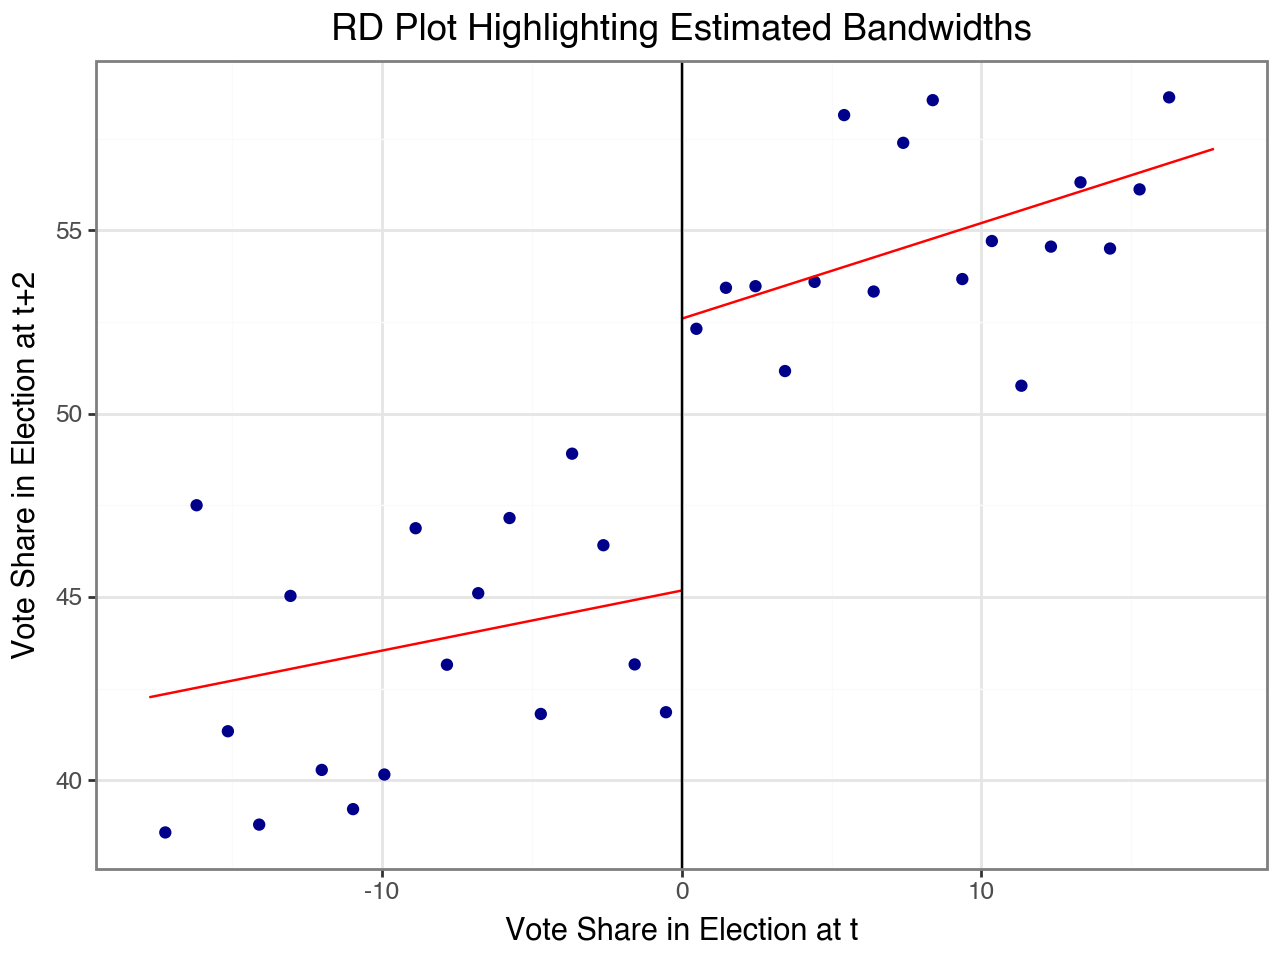

Call: rdplot
Number of Observations:                   683
Kernel:                            Triangular
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           360        323
Number of Effective Obs          360        323
Bandwith poly. fit (h)        17.754     17.754
Number of bins scale               1          1
Bins Selected                     17         18
Average Bin Length             1.044      0.985
Median Bin Length              1.044      0.985
IMSE-optimal bins                8.0        6.0
Mimicking Variance bins         17.0       18.0

Relative to IMSE-optimal:
Implied scale                  2.125        3.0
WIMSE variance weight          0.094      0.036
WIMSE bias weight              0.906      0.964


In [7]:
# Baseline RD robust estimation
baseline_result = rdrobust(y=vote, x=margin)
print("Baseline RD Result:")
print(baseline_result)

# RD plot using estimated bandwidths
h_l, h_r = baseline_result.bws.loc['h', :].values
subset = ((-h_l <= margin) & (margin <= h_r)).values

rdplot(
    y=vote, x=margin, subset=subset,
    binselect="esmv", kernel="triangular", h=[h_l, h_r], p=1,
    title="RD Plot Highlighting Estimated Bandwidths",
    y_label="Vote Share in Election at t+2",
    x_label="Vote Share in Election at t"
)

### Baseline with Covariates

In [9]:
# Covariates for RD estimation
covariates = data[['class', 'termshouse', 'termssenate']]

# RD estimation with covariates
result_with_covariates = rdrobust(y=vote, x=margin, covs=covariates)
print("RD Result with Covariates:")
print(result_with_covariates)

# Check balance of covariates
covariates_with_population = data[['class', 'termshouse', 'termssenate', 'population']]
balance = pd.DataFrame(columns=["RD Effect", "Robust p-val"], index=covariates_with_population.columns)

for cov in covariates_with_population.columns:
    balance_result = rdrobust(y=data[cov], x=margin)
    balance.loc[cov, "RD Effect"] = balance_result.Estimate["tau.us"].values[0]
    balance.loc[cov, "Robust p-val"] = balance_result.pv.iloc[2].values[0]

print("Covariate Balance Check:")
print(balance)

RD Result with Covariates:
Call: rdrobust
Number of Observations:                  1108
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           491        617
Number of Unique Obs.            491        580
Number of Effective Obs.         315        283
Bandwidth Estimation          18.033     18.033
Bandwidth Bias                28.988     28.988
rho (h/b)                      0.622      0.622

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        6.85    1.407    4.869   1.120e-06     [4.093, 9.607]
Robust                 -        -    4.201   2.659e-05    [3.728, 10.249]

C